In [40]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier  
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score  
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import itertools
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
np.set_printoptions(threshold=np.nan)

data = pd.read_csv("../Data/preprocessed_final.csv")
# pdata = pdata.drop(["Unnamed: 0"], axis=1)
data
data['Conditie'] = data['Conditie'].map({'norm': 0,  'bril': 1})
data = data.drop(data[data["Conditie"] > 0].index)
# pdata = pdata.drop(pdata[pdata.Alcohol.eq(0)].sample(82).index)

data['Alcohol_Class'] = data['Alcohol'].astype(float)
conditions = [
    (data['Alcohol'] == 0),
    (data['Alcohol'] > 0) & (data['Alcohol'] < 1.5),
    (data['Alcohol'] > 1.5)]
choices = [0,1,2]
data['Alcohol_Class'] = np.select(conditions, choices, default=0)
data.groupby('Alcohol_Class').count()

,Conditie,SubjectID,Height,Weight,Age,BMI,Alcohol,Balance_MeanVelocity,GaitVelocity,MovementVelocity,std_SegmentData,mad_SegmentData,mean_StepLength,GaitTime
Alcohol_Class,,,,,,,,,,,,,,
0,90,90,90,90,90,90,90,90,90,90,90,90,90,90
1,60,60,60,60,60,60,60,60,60,60,60,60,60,60
2,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [41]:
#Splits data into training and validation according to specified ratio
def validation_split(data, ratio):
    sidlist = data['SubjectID'].unique()
    gdata = [data[data['SubjectID']==sid] for sid in sidlist]
    np.random.shuffle(gdata)
    N = len(gdata)
    training = gdata[:int(ratio*N)]
    validation = gdata[(int(ratio*N)):]
    return training,validation

# Converts the arrays in a list to one flattend dataframe
def flatten(data, variable_list):
    return pd.DataFrame(np.vstack(data), columns=variable_list)

def get_split_data(originaldata, variable_list, ratio):
    data = originaldata[variable_list]
    training,validation = validation_split(data, 0.7)
    training = flatten(training, variable_list)
    validation = flatten(validation, variable_list)

    X_train = training.drop(['Alcohol_Class', 'SubjectID'], axis=1)
    y_train = training['Alcohol_Class']
    X_train = X_train.astype(float)
    y_train = y_train.astype(int)
    
    X_test = validation.drop(['Alcohol_Class', 'SubjectID'], axis=1)
    y_test = validation['Alcohol_Class']
    X_test = X_test.astype(float)
    y_test = y_test.astype(int)
    return X_train, X_test, y_train, y_test

collist =  ['SubjectID', 'Alcohol_Class', 'GaitTime', 'mean_StepLength', 'Height']
X_train, X_test, y_train, y_test = get_split_data(data, collist , 0.7)


X_train = np.array(X_train, dtype=float)
y_train = np.array(y_train, dtype=int)

X_test = np.array(X_test, dtype=float)
y_test = np.array(y_test, dtype=int)



In [42]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Make an instance of the Model
pca = PCA(n_components=2)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

error = []
for i in range(1, 40):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test)) 
j = error.index(min(error)) +1

classifier = KNeighborsClassifier(n_neighbors=j)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

Confusion matrix, without normalization
[[25  1]
 [17  4]]


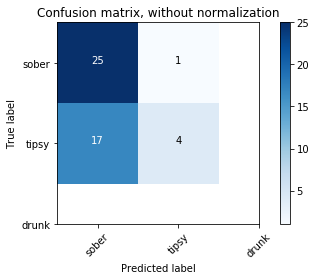

In [43]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['sober', 'tipsy', 'drunk'],
                      title='Confusion matrix, without normalization')

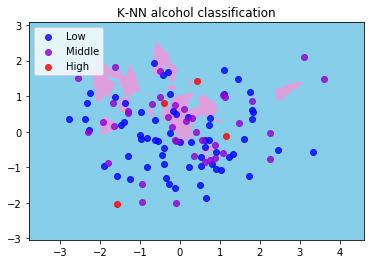

In [44]:
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap
cmap_back = ListedColormap(['skyblue', 'plum'])
h = .02  # step size in the mesh
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_back)


colors = ['blue', 'darkviolet', 'red']
for label in np.unique(y_train):
    indices = np.where(y_train == label)
    plt.scatter(X_train[indices, 0], X_train[indices, 1], c=colors[label], alpha=0.8, 
                label=' {}'.format(label))


labels = ['Low', 'Middle', 'High']
plt.legend(labels)
plt.title('K-NN alcohol classification')
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.savefig('K-NN_alcohol_classification')
plt.show()

In [45]:
variable_list = ['SubjectID', 'Alcohol_Class', 'GaitTime', 'mean_StepLength']

def make_decisions(originaldata, variable_list):
    data = originaldata[variable_list]
    training,validation = validation_split(data, 0.7)
    training = flatten(training, variable_list)
    validation = flatten(validation, variable_list)

    X_train = training.drop(['Alcohol_Class', 'SubjectID'], axis=1)
    y_train = training['Alcohol_Class']
    X_train = X_train.astype(float)
    y_train = y_train.astype(int)
    
    X_test = validation.drop(['Alcohol_Class', 'SubjectID'], axis=1)
    y_test = validation['Alcohol_Class']
    X_test = X_test.astype(float)
    y_test = y_test.astype(int)
    
    scaler = StandardScaler()

    # Fit on training set only.
    scaler.fit(X_train)

    # Apply transform to both the training set and the test set.
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Make an instance of the Model
    pca = PCA(n_components=2)
    pca.fit(X_train)

    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    error = []
    for i in range(1, 40):  
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test)
        error.append(np.mean(pred_i != y_test)) 
    j = error.index(min(error)) +1
    
    classifier = KNeighborsClassifier(n_neighbors=j)
    classifier.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred = classifier.predict(X_test)


    return accuracy_score(y_test, y_pred)*100



make_decisions(data, variable_list)

72.3404255319149

In [46]:
print('GaitVelocity, MovementVelocity:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'GaitVelocity', 'MovementVelocity']) for i in range(100)]), 2),'%.')
print('GaitVelocity, MovementVelocity, Balance_MeanVelocity:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'GaitVelocity', 'MovementVelocity', 'Balance_MeanVelocity']) for i in range(100)]), 2),'%.')
print('GaitVelocity, Balance_MeanVelocity:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'GaitVelocity', 'Balance_MeanVelocity']) for i in range(100)]), 2),'%.')
print('MovementVelocity, Balance_MeanVelocity:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'MovementVelocity', 'Balance_MeanVelocity']) for i in range(100)]), 2),'%.')



GaitVelocity, MovementVelocity: 62.09 %.
GaitVelocity, MovementVelocity, Balance_MeanVelocity: 62.15 %.
GaitVelocity, Balance_MeanVelocity: 62.57 %.
MovementVelocity, Balance_MeanVelocity: 61.68 %.


In [26]:
print('mad_SegmentData, mean_StepLength:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class','mean_StepLength', 'mad_SegmentData']) for i in range(100)]), 2),'%.')
print('mean_StepLength, std_SegmentData:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, mad_SegmentData:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mean_StepLength', 'GaitTime', 'mad_SegmentData']) for i in range(100)]), 2),'%.')
print('std_SegmentData, GaitVelocity, MovementVelocity, mean_StepLength:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'GaitVelocity', 'MovementVelocity', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, GaitVelocity, MovementVelocity, mean_StepLength, std_SegmentData:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'GaitVelocity', 'MovementVelocity', 'mean_StepLength', 'GaitTime', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, Height:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mean_StepLength', 'GaitTime', 'Height']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, Age:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mean_StepLength', 'GaitTime', 'Age']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Height:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mean_StepLength', 'Height']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Age:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mean_StepLength', 'Age']) for i in range(100)]), 2),'%.')
print('GaitTime, Height:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'GaitTime', 'Height']) for i in range(100)]), 2),'%.')
print('std_SegmentData, Height:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mad_SegmentData', 'Height']) for i in range(100)]), 2),'%.')
print('mad_SegmentData, Age:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mad_SegmentData', 'Age']) for i in range(100)]), 2),'%.')
print('std_SegmentData, GaitTime, mean_StepLength:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'GaitTime', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')

mad_SegmentData, mean_StepLength: 59.52 %.
mean_StepLength, std_SegmentData: 59.45 %.
GaitTime, mean_StepLength, mad_SegmentData: 60.99 %.
std_SegmentData, GaitVelocity, MovementVelocity, mean_StepLength: 62.71 %.
GaitTime, GaitVelocity, MovementVelocity, mean_StepLength, std_SegmentData: 62.11 %.
GaitTime, mean_StepLength, Height: 61.48 %.
GaitTime, mean_StepLength, Age: 64.81 %.
mean_StepLength, Height: 58.66 %.
mean_StepLength, Age: 62.71 %.
GaitTime, Height: 59.59 %.
std_SegmentData, Height: 58.69 %.
mad_SegmentData, Age: 61.78 %.
std_SegmentData, GaitTime, mean_StepLength: 62.06 %.


In [47]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier  
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score  
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import itertools
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
np.set_printoptions(threshold=np.nan)

data = pd.read_csv("../Data/preprocessed_final.csv")
# pdata = pdata.drop(["Unnamed: 0"], axis=1)
data
data['Conditie'] = data['Conditie'].map({'norm': 0,  'bril': 1})
data = data.drop(data[data["Conditie"] > 0].index)
# pdata = pdata.drop(pdata[pdata.Alcohol.eq(0)].sample(82).index)

data['Alcohol_Class'] = data['Alcohol'].astype(float)
conditions = [
    (data['Alcohol'] == 0),
    (data['Alcohol'] > 0) & (data['Alcohol'] < 0.5),
    (data['Alcohol'] > 0.5)]
choices = [0,1,2]
data['Alcohol_Class'] = np.select(conditions, choices, default=0)
data.groupby('Alcohol_Class').count()

,Conditie,SubjectID,Height,Weight,Age,BMI,Alcohol,Balance_MeanVelocity,GaitVelocity,MovementVelocity,std_SegmentData,mad_SegmentData,mean_StepLength,GaitTime
Alcohol_Class,,,,,,,,,,,,,,
0,90,90,90,90,90,90,90,90,90,90,90,90,90,90
1,28,28,28,28,28,28,28,28,28,28,28,28,28,28
2,36,36,36,36,36,36,36,36,36,36,36,36,36,36


In [48]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Make an instance of the Model
pca = PCA(n_components=2)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

error = []
for i in range(1, 40):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test)) 
j = error.index(min(error)) +1

classifier = KNeighborsClassifier(n_neighbors=j)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

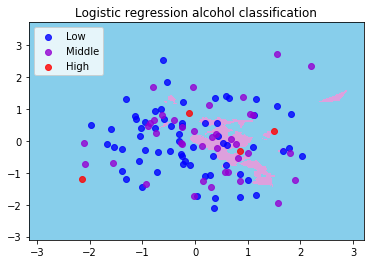

In [49]:
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap
cmap_back = ListedColormap(['skyblue', 'plum'])
h = .02  # step size in the mesh
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_back)


colors = ['blue', 'darkviolet', 'red']

for label in np.unique(y_train):
    indices = np.where(y_train == label)
    plt.scatter(X_train[indices, 0], X_train[indices, 1], c=colors[label], alpha=0.8, 
                label=' {}'.format(label))

labels = ['Low', 'Middle', 'High']
plt.legend(labels)
plt.title('Logistic regression alcohol classification')
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.savefig('Log_reg')
plt.show()

In [50]:
#Splits data into training and validation according to specified ratio
def validation_split(data, ratio):
    sidlist = data['SubjectID'].unique()
    gdata = [data[data['SubjectID']==sid] for sid in sidlist]
    np.random.shuffle(gdata)
    N = len(gdata)
    training = gdata[:int(ratio*N)]
    validation = gdata[(int(ratio*N)):]
    return training,validation

# Converts the arrays in a list to one flattend dataframe
def flatten(data, variable_list):
    return pd.DataFrame(np.vstack(data), columns=variable_list)

def get_split_data(originaldata, variable_list, ratio):
    data = originaldata[variable_list]
    training,validation = validation_split(data, 0.7)
    training = flatten(training, variable_list)
    validation = flatten(validation, variable_list)

    X_train = training.drop(['Alcohol_Class', 'SubjectID'], axis=1)
    y_train = training['Alcohol_Class']
    X_train = X_train.astype(float)
    y_train = y_train.astype(int)
    
    X_test = validation.drop(['Alcohol_Class', 'SubjectID'], axis=1)
    y_test = validation['Alcohol_Class']
    X_test = X_test.astype(float)
    y_test = y_test.astype(int)
    return X_train, X_test, y_train, y_test

collist =  ['SubjectID', 'Alcohol_Class', 'GaitTime', 'mean_StepLength']
X_train, X_test, y_train, y_test = get_split_data(data, collist , 0.7)


X_train = np.array(X_train, dtype=float)
y_train = np.array(y_train, dtype=int)

X_test = np.array(X_test, dtype=float)
y_test = np.array(y_test, dtype=int)



In [51]:
variable_list = ['SubjectID', 'Alcohol_Class', 'GaitTime', 'mean_StepLength']

def make_decisions(originaldata, variable_list):
    data = originaldata[variable_list]
    training,validation = validation_split(data, 0.7)
    training = flatten(training, variable_list)
    validation = flatten(validation, variable_list)

    X_train = training.drop(['Alcohol_Class', 'SubjectID'], axis=1)
    y_train = training['Alcohol_Class']
    X_train = X_train.astype(float)
    y_train = y_train.astype(int)
    
    X_test = validation.drop(['Alcohol_Class', 'SubjectID'], axis=1)
    y_test = validation['Alcohol_Class']
    X_test = X_test.astype(float)
    y_test = y_test.astype(int)
    
    scaler = StandardScaler()

    # Fit on training set only.
    scaler.fit(X_train)

    # Apply transform to both the training set and the test set.
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Make an instance of the Model
    pca = PCA(n_components=2)
    pca.fit(X_train)

    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    error = []
    for i in range(1, 40):  
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test)
        error.append(np.mean(pred_i != y_test)) 
    j = error.index(min(error)) +1
    
    classifier = KNeighborsClassifier(n_neighbors=j)
    classifier.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred = classifier.predict(X_test)

    return accuracy_score(y_test, y_pred)*100



make_decisions(data, variable_list)

70.2127659574468

In [52]:
print('GaitVelocity, MovementVelocity:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'GaitVelocity', 'MovementVelocity']) for i in range(100)]), 2),'%.')
print('GaitVelocity, MovementVelocity, Balance_MeanVelocity:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'GaitVelocity', 'MovementVelocity', 'Balance_MeanVelocity']) for i in range(100)]), 2),'%.')
print('GaitVelocity, Balance_MeanVelocity:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'GaitVelocity', 'Balance_MeanVelocity']) for i in range(100)]), 2),'%.')
print('MovementVelocity, Balance_MeanVelocity:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'MovementVelocity', 'Balance_MeanVelocity']) for i in range(100)]), 2),'%.')



GaitVelocity, MovementVelocity: 60.77 %.
GaitVelocity, MovementVelocity, Balance_MeanVelocity: 59.87 %.
GaitVelocity, Balance_MeanVelocity: 61.13 %.
MovementVelocity, Balance_MeanVelocity: 60.23 %.


In [32]:
print('mad_SegmentData, mean_StepLength:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class','mean_StepLength', 'mad_SegmentData']) for i in range(100)]), 2),'%.')
print('mean_StepLength, std_SegmentData:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, mad_SegmentData:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mean_StepLength', 'GaitTime', 'mad_SegmentData']) for i in range(100)]), 2),'%.')
print('std_SegmentData, GaitVelocity, MovementVelocity, mean_StepLength:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'GaitVelocity', 'MovementVelocity', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, GaitVelocity, MovementVelocity, mean_StepLength, std_SegmentData:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'GaitVelocity', 'MovementVelocity', 'mean_StepLength', 'GaitTime', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, Height:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mean_StepLength', 'GaitTime', 'Height']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, Age:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mean_StepLength', 'GaitTime', 'Age']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Height:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mean_StepLength', 'Height']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Age:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mean_StepLength', 'Age']) for i in range(100)]), 2),'%.')
print('GaitTime, Height:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'GaitTime', 'Height']) for i in range(100)]), 2),'%.')
print('std_SegmentData, Height:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mad_SegmentData', 'Height']) for i in range(100)]), 2),'%.')
print('mad_SegmentData, Age:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mad_SegmentData', 'Age']) for i in range(100)]), 2),'%.')
print('std_SegmentData, GaitTime, mean_StepLength:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'GaitTime', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')

mad_SegmentData, mean_StepLength: 58.01 %.
mean_StepLength, std_SegmentData: 59.32 %.
GaitTime, mean_StepLength, mad_SegmentData: 59.1 %.
std_SegmentData, GaitVelocity, MovementVelocity, mean_StepLength: 59.31 %.
GaitTime, GaitVelocity, MovementVelocity, mean_StepLength, std_SegmentData: 59.96 %.
GaitTime, mean_StepLength, Height: 58.37 %.
GaitTime, mean_StepLength, Age: 61.26 %.
mean_StepLength, Height: 58.67 %.
mean_StepLength, Age: 60.32 %.
GaitTime, Height: 58.95 %.
std_SegmentData, Height: 59.21 %.
mad_SegmentData, Age: 59.44 %.
std_SegmentData, GaitTime, mean_StepLength: 60.21 %.


In [53]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier  
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score  
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import itertools
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
np.set_printoptions(threshold=np.nan)

data = pd.read_csv("../Data/preprocessed_final.csv")
# pdata = pdata.drop(["Unnamed: 0"], axis=1)
data
data['Conditie'] = data['Conditie'].map({'norm': 0,  'bril': 1})
data = data.drop(data[data["Conditie"] > 0].index)

data['Alcohol_Class'] = data['Alcohol'].astype(float)
conditions = [
    (data['Alcohol'] == 0),
    (data['Alcohol'] > 0) & (data['Alcohol'] < 0.5),
    (data['Alcohol'] > 0.5)]
choices = [0,1,2]
data['Alcohol_Class'] = np.select(conditions, choices, default=0)

data = data.drop(data[data.Alcohol_Class.eq(0)].sample(62).index)
data = data.drop(data[data.Alcohol_Class.eq(2)].sample(8).index)
data.groupby('Alcohol_Class').count()

,Conditie,SubjectID,Height,Weight,Age,BMI,Alcohol,Balance_MeanVelocity,GaitVelocity,MovementVelocity,std_SegmentData,mad_SegmentData,mean_StepLength,GaitTime
Alcohol_Class,,,,,,,,,,,,,,
0,28,28,28,28,28,28,28,28,28,28,28,28,28,28
1,28,28,28,28,28,28,28,28,28,28,28,28,28,28
2,28,28,28,28,28,28,28,28,28,28,28,28,28,28


In [54]:
#Splits data into training and validation according to specified ratio
def validation_split(data, ratio):
    sidlist = data['SubjectID'].unique()
    gdata = [data[data['SubjectID']==sid] for sid in sidlist]
    np.random.shuffle(gdata)
    N = len(gdata)
    training = gdata[:int(ratio*N)]
    validation = gdata[(int(ratio*N)):]
    return training,validation

# Converts the arrays in a list to one flattend dataframe
def flatten(data, variable_list):
    return pd.DataFrame(np.vstack(data), columns=variable_list)

def get_split_data(originaldata, variable_list, ratio):
    data = originaldata[variable_list]
    training,validation = validation_split(data, 0.7)
    training = flatten(training, variable_list)
    validation = flatten(validation, variable_list)

    X_train = training.drop(['Alcohol_Class', 'SubjectID'], axis=1)
    y_train = training['Alcohol_Class']
    X_train = X_train.astype(float)
    y_train = y_train.astype(int)
    
    X_test = validation.drop(['Alcohol_Class', 'SubjectID'], axis=1)
    y_test = validation['Alcohol_Class']
    X_test = X_test.astype(float)
    y_test = y_test.astype(int)
    return X_train, X_test, y_train, y_test

collist =  ['SubjectID', 'Alcohol_Class', 'GaitTime', 'mean_StepLength']
X_train, X_test, y_train, y_test = get_split_data(data, collist , 0.7)


X_train = np.array(X_train, dtype=float)
y_train = np.array(y_train, dtype=int)

X_test = np.array(X_test, dtype=float)
y_test = np.array(y_test, dtype=int)



In [55]:
variable_list = ['SubjectID', 'Alcohol_Class', 'GaitTime', 'mean_StepLength']

def make_decisions(originaldata, variable_list):
    data = originaldata[variable_list]
    training,validation = validation_split(data, 0.7)
    training = flatten(training, variable_list)
    validation = flatten(validation, variable_list)

    X_train = training.drop(['Alcohol_Class', 'SubjectID'], axis=1)
    y_train = training['Alcohol_Class']
    X_train = X_train.astype(float)
    y_train = y_train.astype(int)
    
    X_test = validation.drop(['Alcohol_Class', 'SubjectID'], axis=1)
    y_test = validation['Alcohol_Class']
    X_test = X_test.astype(float)
    y_test = y_test.astype(int)
    
    scaler = StandardScaler()

    # Fit on training set only.
    scaler.fit(X_train)

    # Apply transform to both the training set and the test set.
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # Make an instance of the Model
    pca = PCA(n_components=2)
    pca.fit(X_train)

    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    error = []
    for i in range(1, 40):  
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test)
        error.append(np.mean(pred_i != y_test)) 
    j = error.index(min(error)) +1
    
    classifier = KNeighborsClassifier(n_neighbors=j)
    classifier.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred = classifier.predict(X_test)

    return accuracy_score(y_test, y_pred)*100



make_decisions(data, variable_list)

42.30769230769231

In [56]:
print('GaitVelocity, MovementVelocity:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'GaitVelocity', 'MovementVelocity']) for i in range(100)]), 2),'%.')
print('GaitVelocity, MovementVelocity, Balance_MeanVelocity:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'GaitVelocity', 'MovementVelocity', 'Balance_MeanVelocity']) for i in range(100)]), 2),'%.')
print('GaitVelocity, Balance_MeanVelocity:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'GaitVelocity', 'Balance_MeanVelocity']) for i in range(100)]), 2),'%.')
print('MovementVelocity, Balance_MeanVelocity:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'MovementVelocity', 'Balance_MeanVelocity']) for i in range(100)]), 2),'%.')



GaitVelocity, MovementVelocity: 43.65 %.
GaitVelocity, MovementVelocity, Balance_MeanVelocity: 43.38 %.
GaitVelocity, Balance_MeanVelocity: 46.54 %.
MovementVelocity, Balance_MeanVelocity: 45.31 %.


In [38]:
print('mad_SegmentData, mean_StepLength:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class','mean_StepLength', 'mad_SegmentData']) for i in range(100)]), 2),'%.')
print('mean_StepLength, std_SegmentData:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, mad_SegmentData:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mean_StepLength', 'GaitTime', 'mad_SegmentData']) for i in range(100)]), 2),'%.')
print('std_SegmentData, GaitVelocity, MovementVelocity, mean_StepLength:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'GaitVelocity', 'MovementVelocity', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, GaitVelocity, MovementVelocity, mean_StepLength, std_SegmentData:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'GaitVelocity', 'MovementVelocity', 'mean_StepLength', 'GaitTime', 'std_SegmentData']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, Height:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mean_StepLength', 'GaitTime', 'Height']) for i in range(100)]), 2),'%.')
print('GaitTime, mean_StepLength, Age:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mean_StepLength', 'GaitTime', 'Age']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Height:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mean_StepLength', 'Height']) for i in range(100)]), 2),'%.')
print('mean_StepLength, Age:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mean_StepLength', 'Age']) for i in range(100)]), 2),'%.')
print('GaitTime, Height:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'GaitTime', 'Height']) for i in range(100)]), 2),'%.')
print('std_SegmentData, Height:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mad_SegmentData', 'Height']) for i in range(100)]), 2),'%.')
print('mad_SegmentData, Age:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'mad_SegmentData', 'Age']) for i in range(100)]), 2),'%.')
print('std_SegmentData, GaitTime, mean_StepLength:', round(np.mean([make_decisions(data, ['SubjectID', 'Alcohol_Class', 'GaitTime', 'mean_StepLength', 'std_SegmentData']) for i in range(100)]), 2),'%.')

mad_SegmentData, mean_StepLength: 43.2 %.
mean_StepLength, std_SegmentData: 41.85 %.
GaitTime, mean_StepLength, mad_SegmentData: 42.24 %.
std_SegmentData, GaitVelocity, MovementVelocity, mean_StepLength: 43.5 %.
GaitTime, GaitVelocity, MovementVelocity, mean_StepLength, std_SegmentData: 43.85 %.
GaitTime, mean_StepLength, Height: 41.13 %.
GaitTime, mean_StepLength, Age: 45.55 %.
mean_StepLength, Height: 43.17 %.
mean_StepLength, Age: 47.01 %.
GaitTime, Height: 38.58 %.
std_SegmentData, Height: 38.68 %.
mad_SegmentData, Age: 40.88 %.
std_SegmentData, GaitTime, mean_StepLength: 41.2 %.


In [18]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Make an instance of the Model
pca = PCA(n_components=2)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

error = []
for i in range(1, 40):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test)) 
j = error.index(min(error)) +1

classifier = KNeighborsClassifier(n_neighbors=j)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)


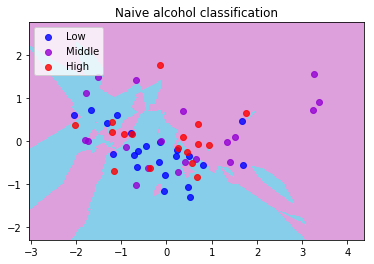

In [19]:
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap
cmap_back = ListedColormap(['skyblue', 'plum'])
h = .02  # step size in the mesh
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_back)


colors = ['blue', 'darkviolet', 'red']

for label in np.unique(y_train):
    indices = np.where(y_train == label)
    plt.scatter(X_train[indices, 0], X_train[indices, 1], c=colors[label], alpha=0.8, 
                label=' {}'.format(label))

labels = ['Low', 'Middle', 'High']
plt.legend(labels)
plt.title('Naive alcohol classification')
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.savefig('Bayes_alcohol')
plt.show()